# Flir Tau2 Temperature Calibration
The common functionality of every thermal camera is to provide a pixel-wise temperature estimation of the scene.
This notebook will explore the relationship between the raw grey levels and the temperature of the scene.

To that end, a black-body is being captured by the camera at fixed (known) temperature levels. the grey levels obtained at each temperature are then used, together with the known temperatures, to construct a regression model for estimating the temperature given the grey-level

## Packages and data imports:

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path().cwd().parent))
from tools import get_measurements, FilterWavelength, FilterWavelength

import matplotlib
from plots import showFacetImages
%load_ext autoreload
%autoreload 2
%matplotlib widget

matplotlib.rcParams.update({'font.size': 14})

path_to_files = Path.cwd()
while not (path_to_files / "rawData").is_dir():
    path_to_files = path_to_files.parent
path_to_files = path_to_files / "rawData" / 'calib' / 'tlinear_0'

meas_panchromatic, _, _, _, list_blackbody_temperatures, _ =\
    get_measurements(path_to_files, filter_wavelength=FilterWavelength.PAN, fast_load=True, do_prefilt=False)


calculating power: 100%|██████████| 21/21 [00:09<00:00,  2.29it/s]


## Linear Fit
First, we assume a linear model between temperature and grey-level, and perform a linear regression.
$$GL = \hat{\text{intercept}} \times T +\hat{\text{slope}}$$

*Remark*: For the regression parameters estimation, we use only every 2nd measurement in order to avoid overfitting, and use the dropped-out measurements as a validation set.



Now, we move forward to calculating and visualizing the estimated parameters for all image pixels:

Pre-Processing Variables For Regression...
Pre-Processing is Complete!
Performing the regression (this might take a few seconds...)
Regression is complete!


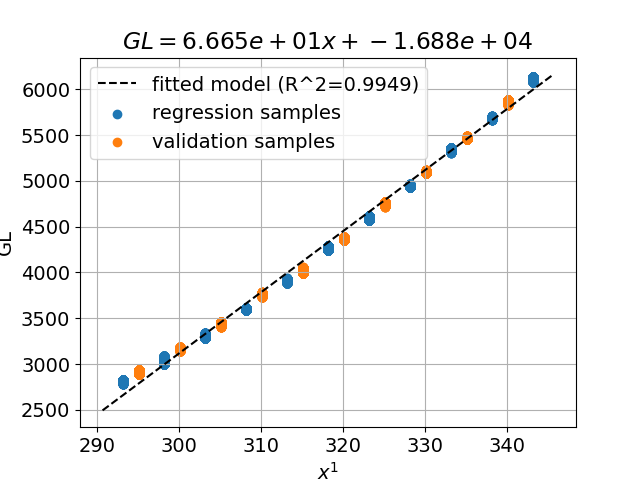

In [2]:
from regression import GlRegressor
import numpy as np
from tools import c2k, k2c

path_to_models = Path.cwd()
while not (path_to_models / "models").is_dir():
    path_to_models = path_to_files.parent
path_to_models = path_to_models / "models"


list_blackbody_temperatures = np.asarray(list_blackbody_temperatures)
gl_regressor = GlRegressor(x_label="T")

def get_regression(re_run_regression, deg=1, feature_power=1, model_name=""):
    f_name = model_name + ".pkl"
    if re_run_regression:
        gl_regressor.fit(c2k(list_blackbody_temperatures),
                         meas_panchromatic, deg=deg, feature_power=feature_power, debug=True)
        gl_regressor.save_model(path_to_models / f_name)
    else:
        gl_regressor.load_model(path_to_models / f_name)


get_regression(re_run_regression=True, model_name="t2gl_1ord")


We are also interested in estimating the temperature, based on the acquired grey-levels (the inverse model):
$$ \hat{GL} = slope \times T + \text{intercept} \Rightarrow \hat{T} = \frac{GL - \text{intercept}}{\text{slope}} $$


In [4]:
def eval_inverse():
    t_hat = k2c(gl_regressor.predict(meas_panchromatic, is_inverse=True))
    ax_lbls = {"xlabel": "BB Temperature[C]", "ylabel": "Estimation Error"}
    err_df = gl_regressor.eval(list_blackbody_temperatures, t_hat, list_blackbody_temperatures, debug=True, ax_lbls=ax_lbls)

    print("Estimation Statistics:\n")
    err_df.describe()

eval_inverse()


Calculating predictions (this might take a few seconds)...
Predictions are ready!


A few observations can be made based on the obtained statistics:
1. The linear model isn't a very good estimate for many operating points, with an RMSE of > 2C in the worst case, and >1C for more than half the operating points.
2. The standard-deviation of all operating points is incredibely small, suggesting that the error trend is very similar for all pixels

These observations give hope that a better model(perhaps a higher degree polynomial) will result in a better fit for all pixels.

Regardless of the suggested models, a proper evaluation should be based on a validation set of measurements that weren't used for constructing the model.


## Quadratic Fit
Following the observations of the linear-regression, it appears that the linear model is underfit for the data at hand. Hence, we'll try to fit a 2nd order (quadratic) polynomial model and test it's performance:


Pre-Processing Variables For Regression...
Pre-Processing is Complete!
Performing the regression (this might take a few seconds...)
Regression is complete!


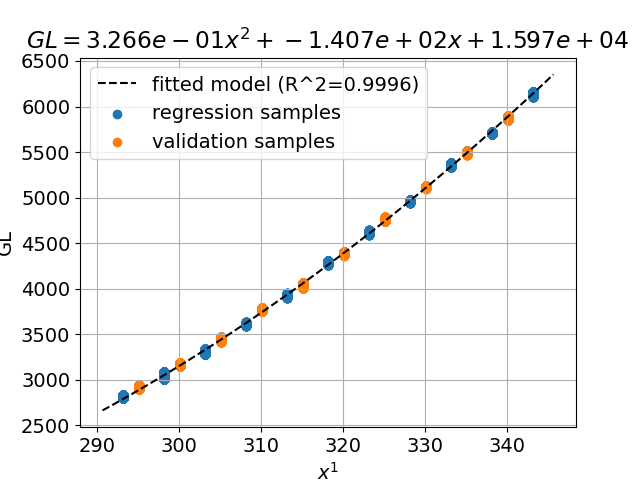

In [ ]:
get_regression(re_run_regression=True, model_name="t2gl_2ord", deg=2)


In the quadratic fit case, there isn't a unique solution for the inverse model (mathematically there are 2 solutions). However, as all temperatures used for the regression are positive and as the fit's derivative in the region of interest is positive - we know that the correct solution is the greater one, allowing us to solve for T.

In [ ]:
eval_inverse()

Calculating predictions (this might take a few seconds)...


TypeError: ufunc 'bitwise_xor' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

## Physical Model
While both the quadratic model provides a much better approximation than the linear one, there is no physical justification for the correctness of this model. 

According to Plank's law, the spectral radiance density is (expressed in units of frequency rather than wavelength):
$$ \mathcal{B}_\nu(T) = \frac{2h\nu^3}{c^2} \frac{1}{e^{h\nu/kT}-1} $$

Assuming an optimal sensor (constant transfer function of 0dB gain for all frequencies), Stefan-Boltzmann law suggests that the radiance $L$ obtained by integrating $\mathcal{B}_\nu(T)$ over the entire spectrum of frequencies is proportional to the 4th power of the temperature:

$$ \int_{\nu} \mathcal{B}_\nu(T) d\nu = \frac{\sigma}{\pi}T^4 $$

Where $\sigma \approx 5.67 \times 10^{-8} \frac{W}{m^2K^4}$ is the Stefan-Boltzmann constant.

Even if our sensor's spectral response isn't optimal, as long as it's temperature invariant (temperature being the black-body's temperature, not the housing temperature) - the proportionality to the temperature should remain the same. See the justification under the Stefan–Boltzmann law section under wikipedia's black-body radiation article.

In [ ]:
get_regression(re_run_regression=True,
               model_name="t2gl_4ord", feature_power=4)


In [ ]:
eval_inverse()

## SNR
One of the questions that arises is how good the signal-to-noise ratio of the acquired data is.

To answer it, we can estimate the noise level (std) of each operating point, and compare it to the regression model's parameters:

In [ ]:
## calculate the per-pixel std map
std_map = meas_panchromatic.std(axis=1)
showFacetImages(std_map, "Temperature", list_blackbody_temperatures, title="Noise Standard-Deviation Per Operating Point")

We can see that the worst case scenario std is $\approx 25 [\frac{GL}{C}]$. Hence, and under the assumption that the noise is i.i.d (which isn't accurate, as we can see from the intensity-over-frames graphs that it's highly correlated) - we can reduce it by the square-root of the acquired frames number after averaging. E.g, averaging over 3000 framse is expected to reduce the noise std to $\frac{25}{\sqrt{3000}} \approx 0.456$ grey-levels in the worst case.

now, let's compare it to the variation in grey levels vs temperature, according to our best fit model:

In [ ]:
gl_regressor.load_model(path_to_models / "t2gl_quad.pkl")

t_hat, err_df = gl_regressor.validate(debug=True)


As our model is quadratic and convex, the derivative (for positive temperatures) is lower bounded by the linear coefficient, which is in our case $\approx 40[\frac{GL}{C}]$.
Hence, the signal changes in a rate that's $> 40[\frac{GL}{C}]$, whereas the noise is $>25[\frac{GL}{C}]$, so the overall SNR is lower bounded by:

$$SNR >  (\frac{40}{25})^2 = 2.56 = 8.165[db]$$